In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [15]:
chars = sorted(list(set(''.join(words))))
stoi = {c: i+1 for i, c in enumerate(chars)}
stoi['.']=0
itos = {i: c for c, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [70]:
block_size = 3 # context length: 3 characters to predict the next one
X, Y = [], []
for w in words:

    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [71]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [135]:
# build the dataset

def build_dataset(words):
    block_size = 3 # context length: 3 characters to predict the next one
    X, Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, X.dtype, Y.shape, Y.dtype)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.int64 torch.Size([182625]) torch.int64
torch.Size([22655, 3]) torch.int64 torch.Size([22655]) torch.int64
torch.Size([22866, 3]) torch.int64 torch.Size([22866]) torch.int64


In [18]:
C = torch.randn((27, 2)) # Each character has a 2-dimensional embedding

In [22]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-1.2146, -0.3969])

In [23]:
# equivalent to
C[5]

tensor([-1.2146, -0.3969])

In [24]:
C[[5,6,7]]

tensor([[-1.2146, -0.3969],
        [ 0.2964,  0.1218],
        [-0.3554, -2.1371]])

In [25]:
C[torch.tensor([5,6,7])]


tensor([[-1.2146, -0.3969],
        [ 0.2964,  0.1218],
        [-0.3554, -2.1371]])

In [27]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [28]:
W1 = torch.randn((6, 100)) # 3 characters * 2 dimensions each = 6
b1 = torch.randn(100)

In [30]:
emb[:, 0, :].shape, emb[:, 1, :].shape, emb[:, 2, :].shape

(torch.Size([32, 2]), torch.Size([32, 2]), torch.Size([32, 2]))

In [32]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([32, 6])

In [38]:
torch.cat((torch.unbind(emb, 1)), 1).shape

torch.Size([32, 6])

In [39]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [40]:
a.shape

torch.Size([18])

In [41]:
a.view(3,3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [44]:
emb.view(32 ,6) == torch.cat((torch.unbind(emb, 1)), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [49]:
# back to the main glow
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape
# 32, 100
#  1, 100
# will broadcast to
# 32, 100
# 32, 100 - copied 32 times

torch.Size([32, 100])

In [50]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [51]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [55]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
prob.shape

torch.Size([32, 27])

In [56]:
prob[0].sum()

tensor(1.)

In [57]:
prob[torch.arange(32), Y]

tensor([4.8617e-07, 4.4406e-07, 4.4268e-13, 6.5257e-07, 9.7885e-01, 4.0306e-13,
        5.8410e-06, 1.8439e-12, 1.0429e-12, 7.5187e-04, 5.4679e-05, 2.8300e-10,
        1.1382e-08, 1.9577e-11, 1.3147e-03, 8.9101e-01, 8.8538e-06, 7.2686e-08,
        3.4449e-05, 1.8285e-08, 7.6794e-08, 8.7374e-14, 2.6756e-01, 1.7706e-08,
        9.9699e-01, 7.0060e-07, 2.0901e-09, 3.9979e-05, 7.0406e-12, 2.3522e-10,
        1.0953e-09, 3.9857e-01])

In [59]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(15.3511)

In [180]:
# Now make it clean:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]


for p in parameters:
    p.requires_grad = True

sum(p.numel() for p in parameters)

11897

In [137]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [181]:
lri = []
lossi = []
stepi = []

In [190]:

for i in range(50000):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]] # 32, 3, 2
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # 32, 100
    logits = h @ W2 + b2 # 32, 27
    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdim=True)
    #loss = -prob[torch.arange(32), Y].log().mean()
    # equivalent to
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.01 # determined by experiment lrs[i]
    for p in parameters:
        p.data -= lr * p.grad

    #lri.append(lr)
    lossi.append(loss.log10().item())
    stepi.append(i)
    

print(loss.item())


2.5335171222686768


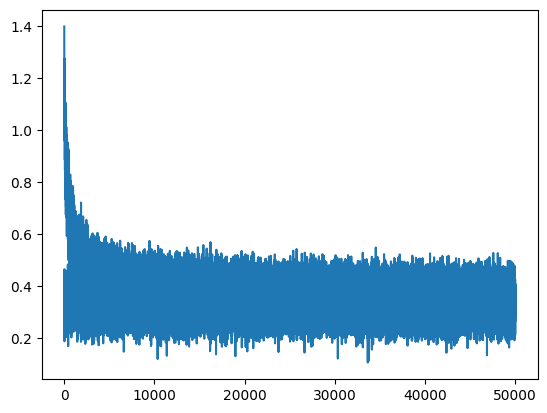

In [191]:
plt.plot(stepi, lossi)

In [192]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1623, grad_fn=<NllLossBackward0>)

In [193]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1826, grad_fn=<NllLossBackward0>)

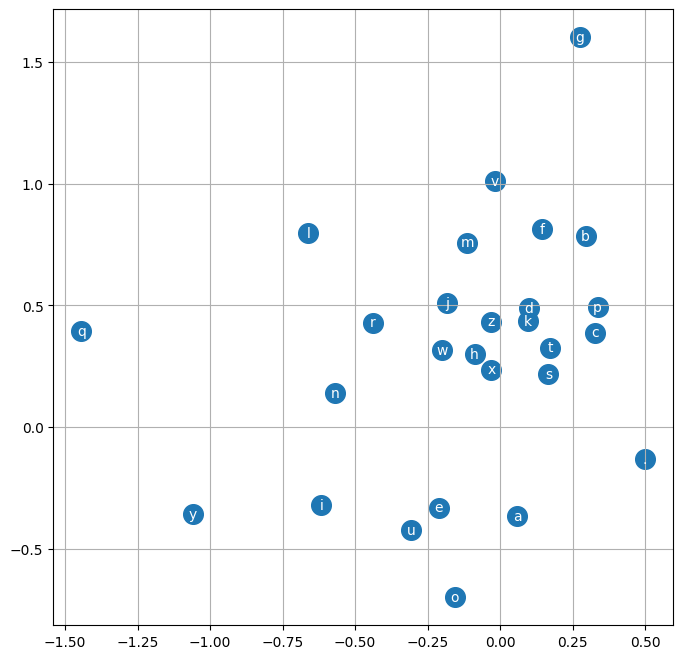

In [164]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [194]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):

    out = []
    context = [0] * 3
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[ix] for ix in out))

cerze.
loulynn.
ila.
kayha.
molimittain.
lufan.
katha.
samiyah.
jaxsi.
gotti.
molie.
cavo.
keyteda.
kaley.
maside.
eniavion.
hatlyn.
hulingavtahlys.
kasor.
breenley.
